# Comparing Option Pricing Methods in kdb+/q

In this notebook, we compare the use of both **Monte Carlo** (MC) and **Quasi-Monte Carlo** (QMC) methods in the process of pricing Asian and European call options. In doing so, we consider the use of two discretization schemes - **standard discretization** and **Brownian bridge construction**. The **Black-Scholes** price for each market is compared to an average price generated using the following combinations of simulation and discretization methods:

- Pseudo-random number generation (MC) with standard discretization.
- Sobol sequences (QMC) with standard discretization.
- Sobol sequences (QMC) with Brownian Bridge construction.

Note that the methods demonstrated below follow the work presented in the paper [S. Kucherenko et. al 2007](http://www.broda.co.uk/gsa/wilmott_GSA_SK.pdf).

The Black-Scholes function for each market produces a closed form solution with a deterministic result, while the MC/QMC functions perform a number of random experiments and return an average price, based on the option type and the strike price.

Once both the Black-Scholes and MC/QMC prices have been calculated for each market, the RMSE can be calculated between the two. This is demonstrated in the final [example](#Example) below. The process is repeated for an increasing number of paths, with resulting errors compared.

### Requirements

The technical dependencies required to run this notebook are as follows:
- [embedPy](https://github.com/KxSystems/embedPy)
- [Sobol C++ library](https://www.broda.co.uk/software.html) - can be found within the option pricing library provided
- matplotlib

---

## Load q scripts

We start by loading in q scripts which include wrappers for the C++ random and sobol sequence number generators, along with the functions required to produce both cumulative and inverse cumulative normal distributions, and graphics functions used throughout this notebook.

In [1]:
\c 20 70
\l ../code/q/rand.q
\l ../code/q/norm.q
\l graphics/graphics.q

---

<a id='BS'></a>
## Black-Scholes Option Pricing

A common model used in finance to calculate the price of call options is Black-Scholes, where the formula required for each market is derived from the [Black Scholes equation](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_equation). In this notebook, we look specifically at the Black-Scholes models for Asian and European call options. The function for each market produces a closed form solution with a deterministic result.

For [European call options](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model), the price of the corresponding option at time $t$, $P(S_{t},t)$, is given by:

$$\begin{eqnarray}
d_{1} = \frac{1}{\sigma\sqrt{T-t}}\Big[ln\Big(\frac{S_{t}}{K}\Big)+\Big((r-q)+\frac{\sigma^{2}}{2}\Big)(T-t)\Big]
\end{eqnarray}$$

$$\begin{eqnarray}
d_{2} = d_{1}-\sigma\sqrt{T-t}
\end{eqnarray}$$

$$\begin{eqnarray}
P(S_{t},t) = S_{t}e^{-q(T-t)}N(d_{1})-Ke^{-r(T-t)}N(d_{2})
\end{eqnarray}$$

Where $T$ is the expiry, $S_{t}$ is the price of the underlying asset at time $t$, $K$ is the strike price of the option, $\sigma$ is the volatility and $r$ is the interest rate. Note that the price is discounted by the dividends, $q$, throughout.

For Asian call options, we implement the same formula, using an adjusted $S_{t}$ and $\sigma^{2}$:

$$\begin{eqnarray}
\mu_{adj} = \frac{1}{2}\Big(r-\frac{\sigma}{2}\Big)\Big(1+\frac{1}{n}\Big)
\end{eqnarray}$$

$$\begin{eqnarray}
\sigma^{2}_{adj} = \frac{\sigma^2}{3}\Big(1+\frac{1}{n}\Big)\Big(1+\frac{1}{2n}\Big)
\end{eqnarray}$$

$$\begin{eqnarray}
{S_{t}}_{adj} = S_{t}e^{\frac{1}{2}\sigma^{2}_{adj}(T-t)+\mu_{adj}-r}
\end{eqnarray}$$

Where $n$ is the number of timesteps.

The Black-Scholes function for each option type are written in q below.

In [2]:
/ Black-Scholes - European
bsEuroCall:{[pd]
 d1:(log[pd[`s]%pd`k]+t*(pd[`r]-pd`q)+.5*v*v)%vrtt:(v:pd`v)*sqrt t:pd`t;
 (pd[`s]*exp[neg t*pd`q]*cnorm1 d1)-pd[`k]*exp[neg t*pd`r]*cnorm1 d1-vrtt}

/ Black-Scholes - Asian
bsAsiaCall:{[n;pd]
 adjmu:.5*((r:pd`r)-.5*v2:v*v:pd`v)*n1:1+1.%n;
 adjv2:(v2%3)*n1*1+.5%n;
 adjS :pd[`s]*exp(t:pd`t)*(hv2:.5*adjv2)+adjmu-r;
 d1:(log[adjS%k:pd`k]+t*(r-q:pd`q)+hv2)%rtv2:sqrt adjv2*t;
 (adjS*exp[neg q*t]*cnorm1 d1)-k*exp[neg r*t]*cnorm1 d1-rtv2}

The required parameters for each function must be specified in a dictionary prior to use and are as follows:
- `s` - Asset price at $t=0$
- `k` - Strike
- `v` - Volatility
- `r` - Interest rate
- `q` - Dividends
- `t` - Expiry

Note that the Black-Scholes price of an Asian call option is also dependent on the number of timesteps `n`. Below we show an example with 512 timesteps.

In [3]:
nsteps:512
pd:`s`k`v`r`q`t!100 100 .2 .05 0 1
-1"European Black Scholes Price: ",string bseuro:bsEuroCall pd;
-1"Asian Black Scholes Price:    ",string bsasia:bsAsiaCall[nsteps]pd;

European Black Scholes Price: 10.45058
Asian Black Scholes Price:    5.556009


---

<a id='MC'></a>
## Monte Carlo and Quasi-Monte Carlo Simulations

In order to generate option prices using MC or QMC methods, a number of experiments must be performed. In each experiment, we:
1. Randomly generate n random numbers, either pseudo-random (MC) or Sobol sequence (QMC).
2. Convert into a normal distribution using `invcnorm`.
3. Convert into a Wiener path random walk using standard discretization or Brownian bridge construction.
4. Convert into an asset price path based on the parameters `s`, `v`, `r`, `q` and `t`.
5. Convert into an option price based on the option type and strike price, `k`.

The prices produced are then averaged to get a final predicted price.

In this section we demonstrate the process using Sobol sequences (QMC) paired with Brownian bridge construction.

### 1. Random number generation

In the example below, 512 random numbers are generated for both pseudo-random numbers and Sobol sequences, with results plotted for comparison.

In [4]:
/ Functions to generate n numbers (random or Sobol) in d dimensions
rdmngen:{[n;d](d;n)#mtrand3 d*n}
sobngen:{[n;d]sobolrand 0;flip sobolrand each n#d}

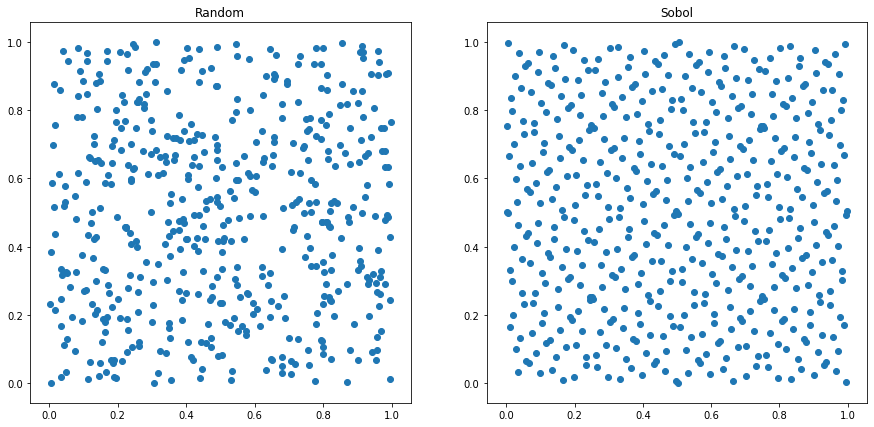

In [5]:
\S 20
data:(rdmngen;sobngen).\:nsteps,2
subplot[data;("Random";"Sobol");2;2#`scatter]

It is clear that the pseudo-random numbers are not evenly distributed, with a points clustering together in some sections, while leaving large portions of white space in others.

In contrast, the Sobol sequence plot exhibits a much more even distribution where points are better spaced out, with few points clumping together.

### 2. Convert to a Gaussian Distribution

The generated sequences are then converted from a uniform distribution to a gaussian distribution. Following this conversion, around 68% of the values lie within one standard deviation, while two standard deviations account for around 95% and three account for 99.7%.

<img src="graphics/gaussian.png" style="height:400px">

<u><b><center>[Gaussian Distribution](https://en.wikipedia.org/wiki/Normal_distribution)</center></b></u>

This is demonstrated using the inverse cumulative normal function, `invcnorm`.

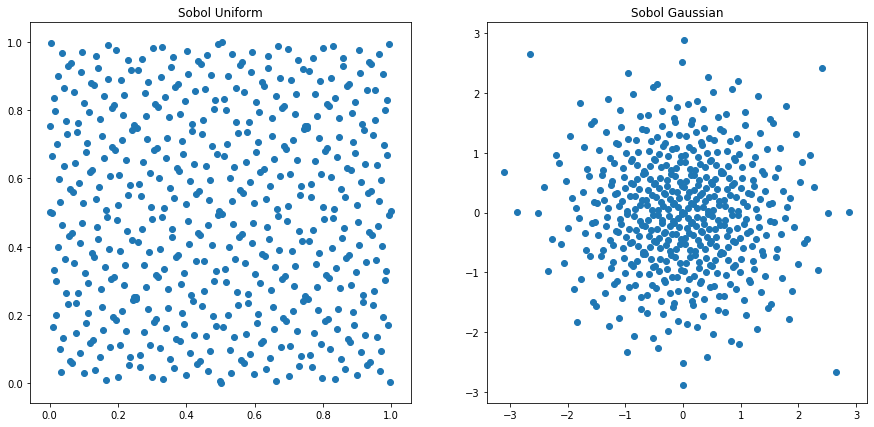

In [6]:
zsob:invcnorm each sob:last data
subplot[(sob;zsob);("Sobol Uniform";"Sobol Gaussian");2;2#`scatter]

The differences between the Gaussian distributions produced for random and Sobol sequences are best demonstrated for a small number of timesteps, e.g. 64. Below we plot the 1D Gaussian distributions for both random and Sobol number generation across 64 timesteps.

In [7]:
/ Returns 1D Gaussian distribution to plot
gausscnv:{[g;n;d]first invcnorm each$[g~`rdm;rdmngen;sobngen][n;d]}

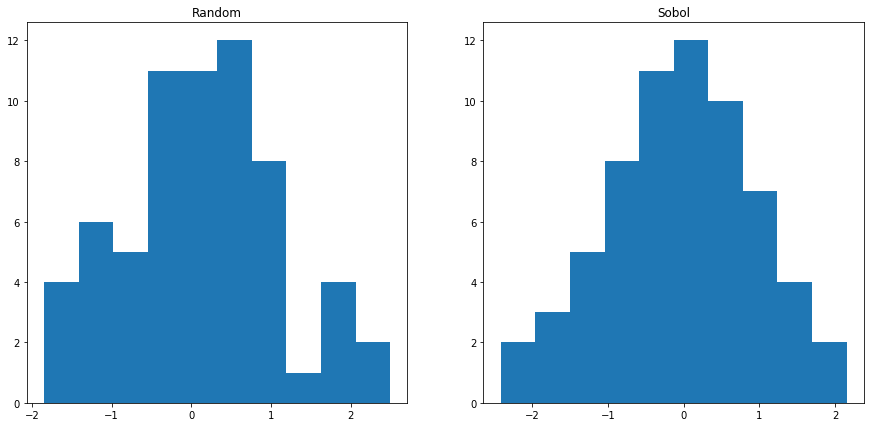

In [8]:
/ Calculates Gaussian variates for 64 steps, in 2 dimensions
dist:gausscnv[;64;2]each`rdm`sob
subplot[dist;("Random";"Sobol");2;2#`hist]

As expected the Sobol sequence exhibits a Gaussian curve with much better statistical properties than the random number sequence.

### 3. Convert into a Wiener path random walk

The starting point for asset price simulation, is the construction of a Wiener path (or Brownian motion). Such paths are built from a set of independent Gaussian variates, using either standard discretization or Brownian bridge construction.

In the standard approximation, the Weiner path is found by taking the cumulative sum of the Gaussian variates.

When constructing a Brownian bridge, the last step of the Wiener path is calculated first, followed by the mid-step, and then bisecting to fill in the gaps until all steps are determined.

An example of building up a Brownian bridge is shown in the diagram below, where we have a total of 14 timesteps (from 1 to 14) and the 0th index, assumed to have a 0 value.

<img src="graphics/bbconstruct.png">

<u><center><b>The construction of a Brownian bridge over 14 steps</b> ([P. Jäckel 2001](http://inis.jinr.ru/sl/M_Mathematics/MV_Probability/MVspf_Stochastics%20in%20finance/Jaeckel%20Monte-Carlo.pdf))</center></u>

The q code to build both a Brownian bridge and Wiener path random walk are shown below.

In [9]:
/ Build a Brownian bridge
bbridge:{[n;dt]
 bb:first flip(n-1).[i.initbb n]\(`bidx`ridx`lidx!3#n-1;((n-1)#0b),1b);
 bb:update lwt:bidx-lidx,rwt:ridx-bidx,sigma:ridx-lidx from bb;
 bb:update lwt%sigma,rwt%sigma,sigma:sqrt dt*lwt*rwt%sigma from bb;
 i.buildpath .[bb;(0;`sigma);:;sqrt n*dt]}

/ Create Wiener path
wpath:{[n;d]$[(::)~d`bb;sums;d`bb]invcnorm$[d`sobol;sobolrand;mtrand3]n}

/ Create an initial Brownian bridge
i.initbb:{[n;d;m]
 if[n<=j:1+d`ridx;j:0];
 d:`bidx`ridx`lidx!(l:j+(k-j+1)div 2;k:j+first where j _m;-1+j+:first where not j _m);
 (d;@[m;l;:;1b])}

/ Create a path to follow
i.buildpath:{[bb;z]if[count[z]<>n:count bb;'`length];
 {[x;bb;z]@[x;bb`bidx;:;z+(x[bb`ridx]*bb`rwt)+$[0>l:bb`lidx;0;x[l]*bb`lwt]]
  }/[((n-1)#0.),z 0;1_bb;1_z*:bb`sigma]}

We can demonstrate how the Brownian bridge is built up using `bbdemo` which will output a table with n timesteps, in this case n = 8, showing the order in which steps are added to the path. Note that `i0` is added here, where we assume that it has has a value equal to 0.

In [10]:
bbdemo:{[n;dt]
 x:1b,'enlist[n#0b],last flip(n-1).[i.initbb n]\(`bidx`ridx`lidx!3#n-1;((n-1)#0b),1b);
 stp::n+1;bbd::"\n"vs .Q.s flip(`$"i",'string til count x)!x:flip(" X")x;}
.z.ts:{if[3<count bbd;-1 system syscmd;if[stp~count[bbd]-3;-1@'2#bbd];-1@'2_3#bbd;bbd::(2#bbd),3_bbd];}

In [11]:
\t 1000
bbdemo[8;1.]


i0 i1 i2 i3 i4 i5 i6 i7 i8
--------------------------
X                         

X                       X 

X           X           X 

X     X     X           X 

X     X     X     X     X 

X  X  X     X     X     X 

X  X  X  X  X     X     X 

X  X  X  X  X  X  X     X 

X  X  X  X  X  X  X  X  X 


When recording the order of steps in the path, we take note of the left and right weights and indices, and the corresponding sigma value for each step in the sequence. This is shown for 512 timesteps and 1 unit of time, with the sigma value for each index in the Brownian bridge subsequently plotted.

In [12]:
dt:1
show 10#b:last value bbex:bbridge[nsteps;dt]

bidx ridx lidx lwt rwt sigma   
-------------------------------
511  511  511          22.62742
255  511  -1   0.5 0.5 11.31371
127  255  -1   0.5 0.5 8       
383  511  255  0.5 0.5 8       
63   127  -1   0.5 0.5 5.656854
191  255  127  0.5 0.5 5.656854
319  383  255  0.5 0.5 5.656854
447  511  383  0.5 0.5 5.656854
31   63   -1   0.5 0.5 4       
95   127  63   0.5 0.5 4       


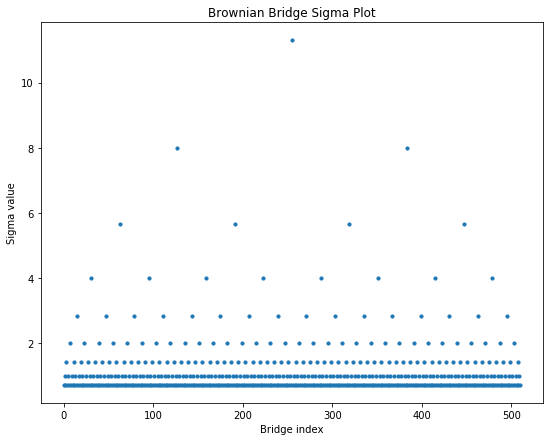

In [13]:
plt[`:figure]`figsize pykw 9 7;
plt[`:title]"Brownian Bridge Sigma Plot";
plt[`:scatter][;;10]. (1_b)`bidx`sigma;
plt[`:xlabel]"Bridge index";
plt[`:ylabel]"Sigma value";
plt[`:show][];

Once the Brownian bridge is intialized, it can be used to transform Gaussian variates into a Wiener path random walk. In the cell below, a Wiener path with 512 timesteps is constructed using a Sobol sequence (of length 512) and the Brownian bridge constructed previously. Note that the function `wpath` takes the following arguments:
- `n` - Number of timesteps.
- `d` - Dictionary indicating whether to use standard discretization or Brownian bridge construction, and whether to use Sobol sequences (`1b`) or pseudo-random numbers (`0b`). If using a Brownian bridge, the initial Brownian bridge must be passed in, if not use `(::)`.

-1.587424 -1.960768 -1.103884 -1.543207 -2.488641 -0.01513004 -0.1454488 2.534878 2.00835 3.565621 3.171461..


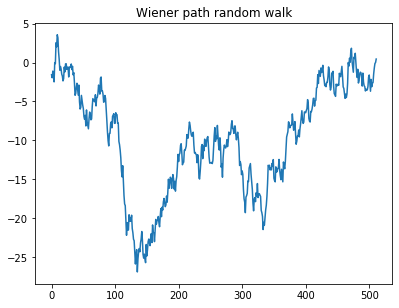

In [14]:
\c 200 110
d:`bb`sobol!(bbex;1b)
show w:wpath[nsteps;d]
plt[`:title]"Wiener path random walk";
plt[`:plot]w;
plt[`:show][];

### 4. Convert into asset price path

At this point it is possible to convert the Wiener path to an asset price path using the function below.

In [15]:
spath:{[n;d;pd]pd[`s]*exp(wpath[n;d]*pd[`v]*sqrt dt)+(1+til n)*dr:(pd[`r]-pd[`q]+.5*v*v:pd`v)*dt:pd[`t]%n}

Here we calculate six different asset price paths and overplot them for comparison. 512 timesteps were again used with Sobol sequences and Brownian bridge approximation.

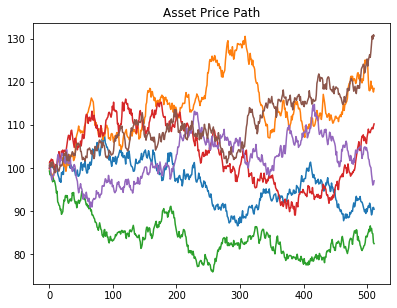

In [16]:
plt[`:title]"Asset Price Path";
do[6;plt[`:plot]spath[nsteps;d;pd]];
plt[`:show][];

### 5. Convert into option price

Lastly, we average the asset price path to find a single price for the MC/QMC method. This will allow for comparison between the predicted price and the Black-Scholes equivalent.

In [17]:
/ Monte Carlo prices for European call option
mcEuroCall:{[m;n;d;pd]exp[neg pd[`r]*pd`t]*avg 0|(last each spath[;d;pd]each m#n)-pd`k}

/ Monte Carlo prices for Asian call option
mcAsiaCall:{[m;n;d;pd]exp[neg pd[`r]*pd`t]*avg 0|((*/)each xexp[;1%n]spath[;d;pd]each m#n)-pd`k}

We demonstrate how to run these functions below for 512 timesteps, 256 paths and 1 trial. Note that the index in `sobolrand` must be reset before each trial. This is done using `sobolrand 0`.

In [18]:
npaths:256
sobolrand 0;-1"European Monte Carlo Price: ",string mcEuroCall[npaths;nsteps;`bb`sobol!(bbex;1b);pd];
sobolrand 0;-1"Asian Monte Carlo Price:    ",string mcAsiaCall[npaths;nsteps;`bb`sobol!(bbex;1b);pd];

European Monte Carlo Price: 10.2713
Asian Monte Carlo Price:    5.367306


Remembering that the Black-Scholes option prices for the same number of timesteps were:

In [19]:
-1"European Black-Scholes Price: ",string bseuro;
-1"Asian Black-Scholes Price:    ",string bsasia;

European Black-Scholes Price: 10.45058
Asian Black-Scholes Price:    5.556009


---

<a id='Example'></a>
## Example

In this section we deploy all of the aforementioned techniques and compare the results.

Note that the below example can be run from the terminal using the following commands:

```q
q)\l op.q
q)loadfile`:init.q
q)loadfile`:code/q/run.q
```
where we load in the functions contained within the Option Pricing library using the first two commands and run the example by loading in `run.q`.

### Parameters

First we need to create a dictionary of parameters as shown previously.

In [20]:
show pd:`s`k`v`r`q`t!100 100 .2 .05 0 1

s| 100
k| 100
v| 0.2
r| 0.05
q| 0
t| 1


We also need to initialize the number of paths (experiments), steps and trials.

In [21]:
l:20                        / Number of trials
show m:"j"$xexp[2;3+til 8]  / Number of paths
n:1024                      / Number of steps

8 16 32 64 128 256 512 1024


Given that the initial Brownian bridge will be the same throughout, it can also be initialized and passed in as an argument.

In [22]:
show 10#last value bb:bbridge[n;1]

bidx ridx lidx lwt rwt sigma   
-------------------------------
1023 1023 1023         32      
511  1023 -1   0.5 0.5 16      
255  511  -1   0.5 0.5 11.31371
767  1023 511  0.5 0.5 11.31371
127  255  -1   0.5 0.5 8       
383  511  255  0.5 0.5 8       
639  767  511  0.5 0.5 8       
895  1023 767  0.5 0.5 8       
63   127  -1   0.5 0.5 5.656854
191  255  127  0.5 0.5 5.656854


### Run experiments
The below functions calculate the RMSE between the Black Scholes and MC/QMC prices for each market and each MC/QMC technique. Note that we reset the `sobolrand` index after each set of trials have been completed.

In [23]:
/ Run all techniques for option pricing
runall:{[bb;pd;l;n;m]
 st:.z.p;0N!i.rcol;e:i.run[`euro;bsEuroCall pd;bb;pd;l;n]each m;
 -1"European: time taken = ",string[.z.p-st],"\n";
 st:.z.p;0N!i.rcol;a:i.run[`asia;bsAsiaCall[n;pd];bb;pd;l;n]each m;
 -1"Asian: time taken = ",string .z.p-st;
 e,a}

/ Show individual results tables
rt:{[t;m]show delete mkt from select from t where mkt=m}

i.d:`bb`sobol!
i.rcol:`mkt`npaths`rmse_bb_sobol`rmse_std_sobol`rmse_std_rdm`prx_bb_sobol`prx_std_sobol`prx_std_rdm`prx_bs
i.rmse:{sqrt avg x*x-:y}
i.run :{[mkt;bs;bb;pd;l;n;m]
 mc:$[mkt~`asia;mcAsiaCall;mcEuroCall][;n;;pd];
 sobolrand 0;ea:i.rmse[bs]a:mc[;i.d(bb;1b)]each k:l#m;
 sobolrand 0;eb:i.rmse[bs]b:mc[;i.d(::;1b)]each k;
 ec:i.rmse[bs]c:mc[;i.d(bb;0b)]each k;
 i.rcol!0N!(mkt;m;ea;eb;ec;last a;last b;last c;bs)}

In [24]:
\c 200 110
r:runall[bb;pd;l;n;m]

`mkt`npaths`rmse_bb_sobol`rmse_std_sobol`rmse_std_rdm`prx_bb_sobol`prx_std_sobol`prx_std_rdm`prx_bs
(`euro;8;2.201757;3.4776;5.209454;12.33432;8.626886;20.38541;10.45058)
(`euro;16;1.246201;2.696852;3.676035;11.53213;13.80096;12.20984;10.45058)
(`euro;32;0.6918545;1.746251;3.015535;11.06003;11.68062;5.68257;10.45058)
(`euro;64;0.3797879;1.174968;1.967627;10.78884;9.449268;9.034532;10.45058)
(`euro;128;0.2065756;0.7232412;1.619673;10.63613;10.58083;7.360597;10.45058)
(`euro;256;0.1115481;0.426031;1.065048;10.5514;10.21488;8.453786;10.45058)
(`euro;512;0.05989714;0.2955258;0.7586819;10.50504;10.43822;11.4056;10.45058)
(`euro;1024;0.03198992;0.2377595;0.3566248;10.4798;10.41221;11.01441;10.45058)
European: time taken = 0D00:01:02.843288000

`mkt`npaths`rmse_bb_sobol`rmse_std_sobol`rmse_std_rdm`prx_bb_sobol`prx_std_sobol`prx_std_rdm`prx_bs
(`asia;8;1.68821;2.013819;2.367783;6.926262;5.342983;7.388339;5.551409)
(`asia;16;0.7919814;1.368621;1.377341;6.038532;6.48064;7.051311;5.551409)
(`asia

### Compare results

At this stage it was possible to plot the results we obtained for the option prices, RMSE and log RMSE values.

#### Option Prices

The plot below shows the option prices produced for each number of paths, compared to the Black-Scholes equivalent (black dashed-line). It is clear that the Sobol-Brownian bridge method (blue) converged the fastest.

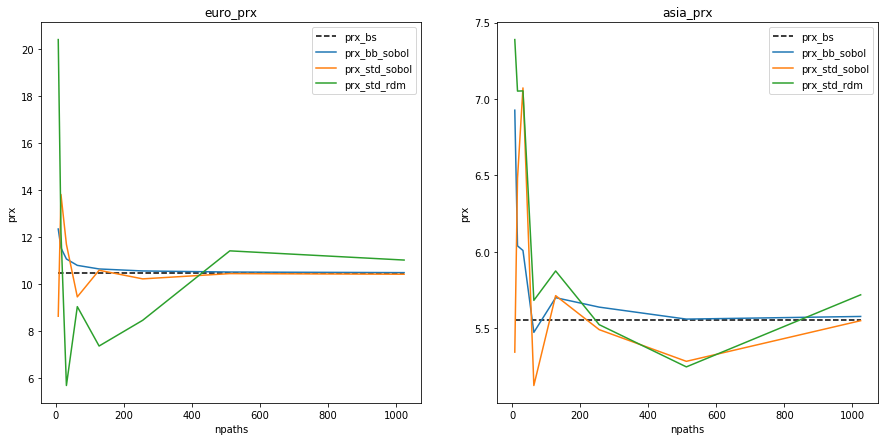

In [25]:
prxerrplot[r;`prx]

#### RMSE
We can also plot the RMSE produced by comparing the prices for each method as they converge to the relative Black-Scholes price. The expected result is again exhibited.

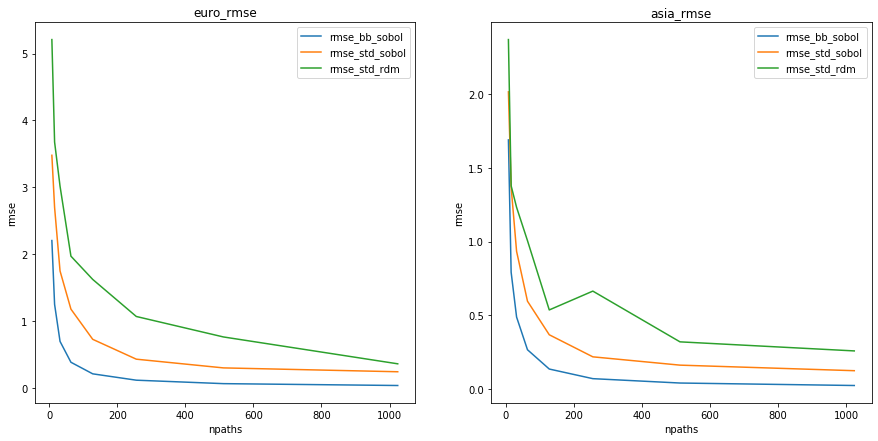

In [26]:
prxerrplot[r;`rmse]

#### Log RMSE
Lastly, we also look at the log RMSE plot as another means of comparison between the methods. Similarly, we see that the Sobol-Brownian bridge method (blue) exhibited superior performance.

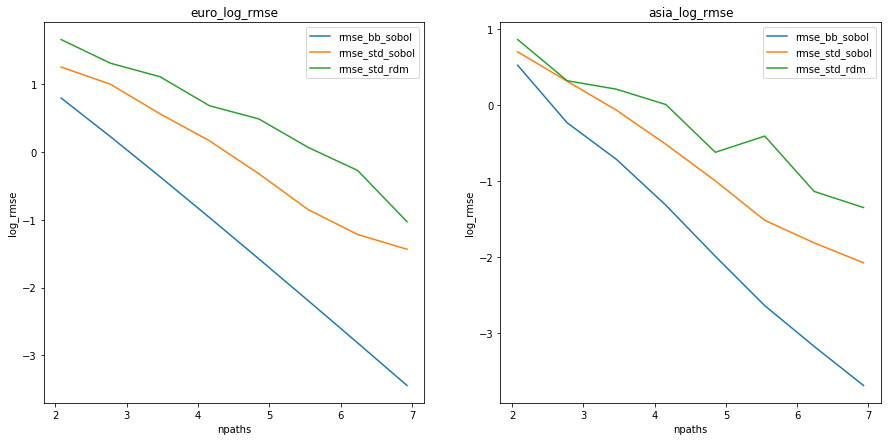

In [27]:
prxerrplot[r;`log]

---

## Conclusion

In this paper we demonstrated that it is possible to calculate option prices using both Black-Scholes and Monte Carlo/Quasi-Monte Carlo methods in kdb+/q. The Monte Carlo/Quasi-Monte Carlo methods used deployed different implementations of both Wiener path approximation and random number generation.

Looking at the results produced, it is clear that both the option price produced and the resulting RMSE/log RMSE converged fastest when compared to the Black-Scholes price for the Quasi-Monte Carlo approach, with Sobol sequence number generation and Brownian bridge construction.

Additionally, by plotting results we have shown that the kdb+/q implementation replicates the original results produced in C++, presented in the paper S. Kucherenko et. al 2007.

---